# Tabular Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

llm_synth = "gemma"
# Caricamento dei dataset
original_data = pd.read_csv('./TabularData/diabetic_data_filtered_250.csv')
synthetic_data = pd.read_csv(f'TabularData/StoryTellingPrompt/{llm_synth}_storytelling_synthetic.csv')

## 1. Visualizzazione delle Distribuzioni

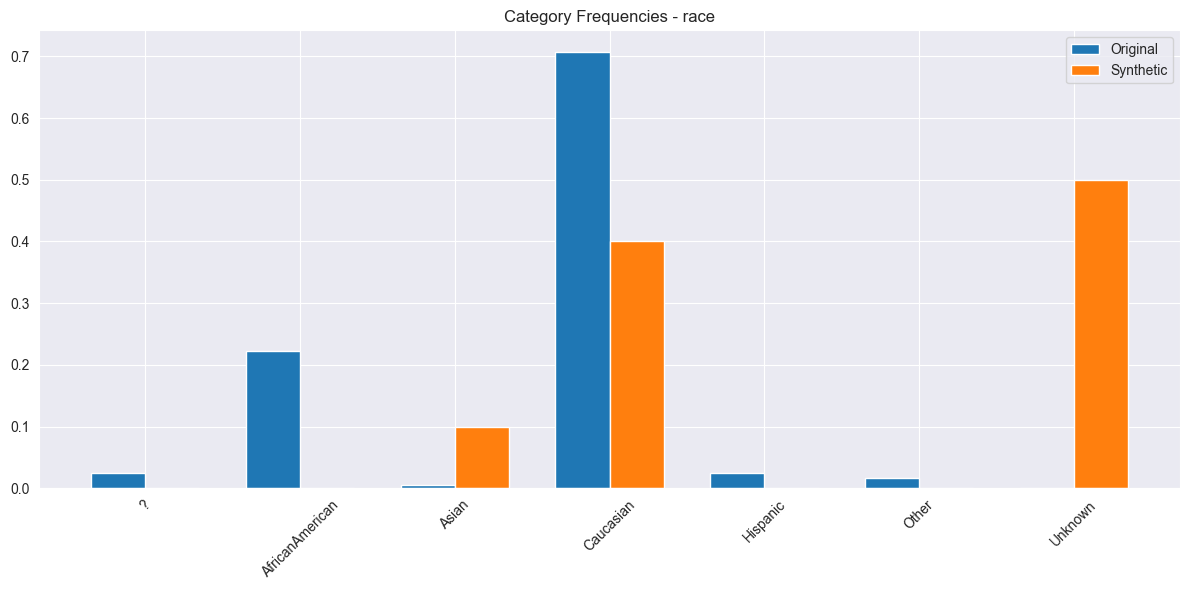

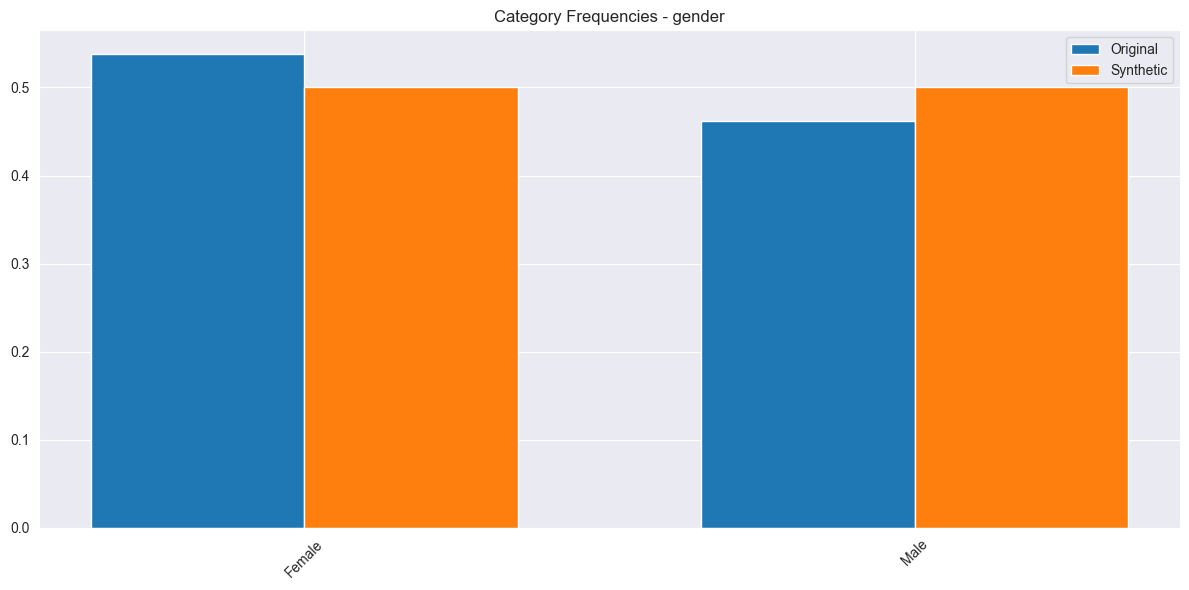

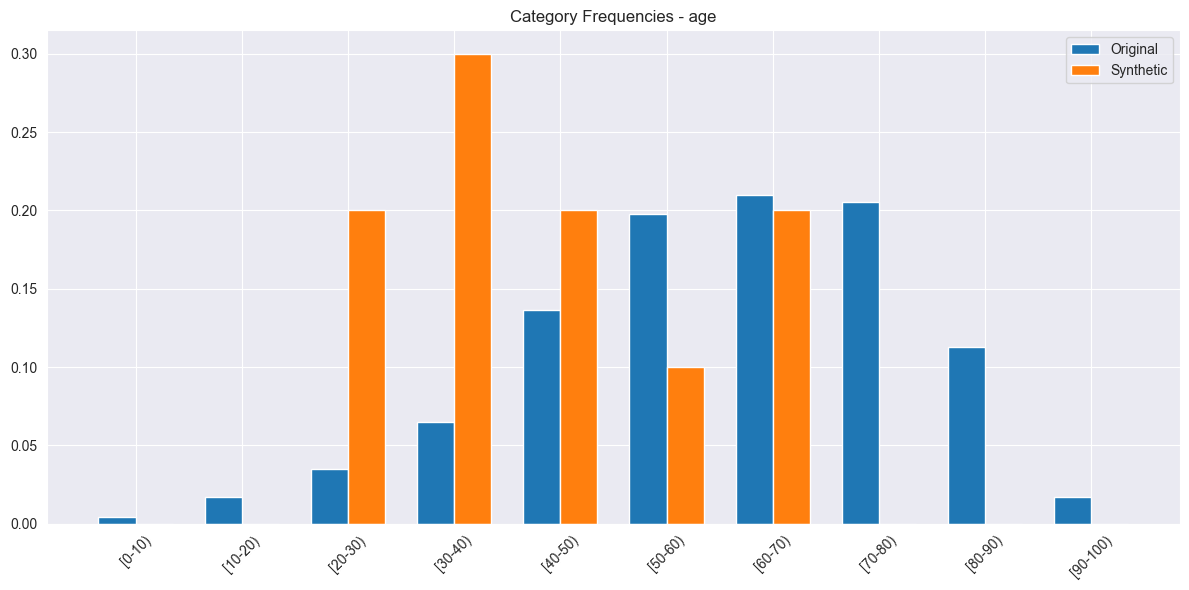

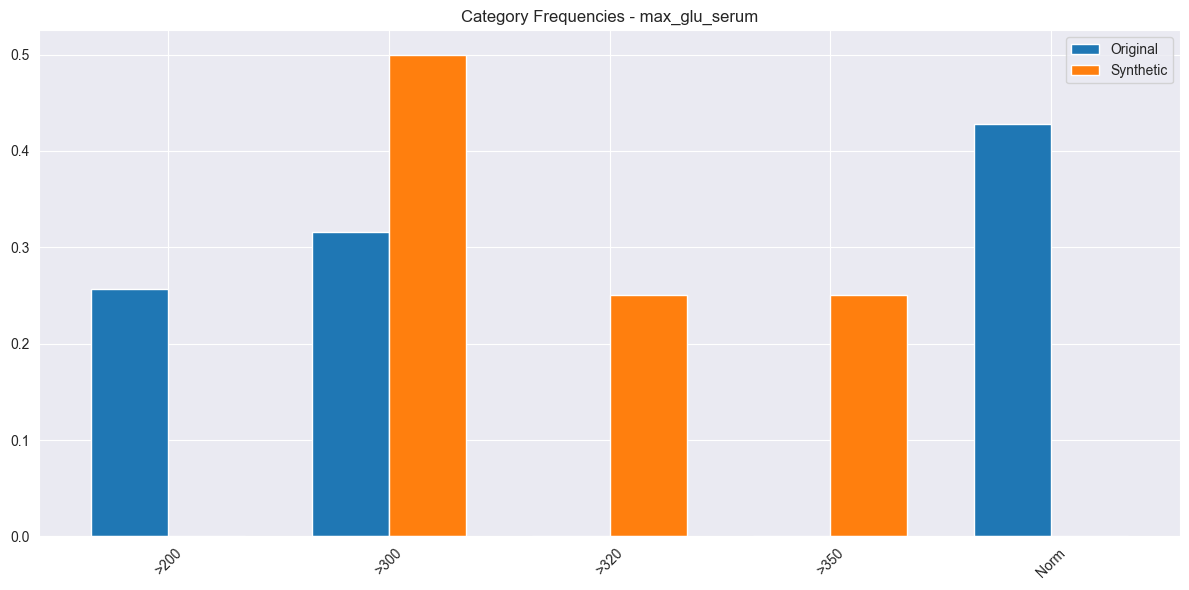

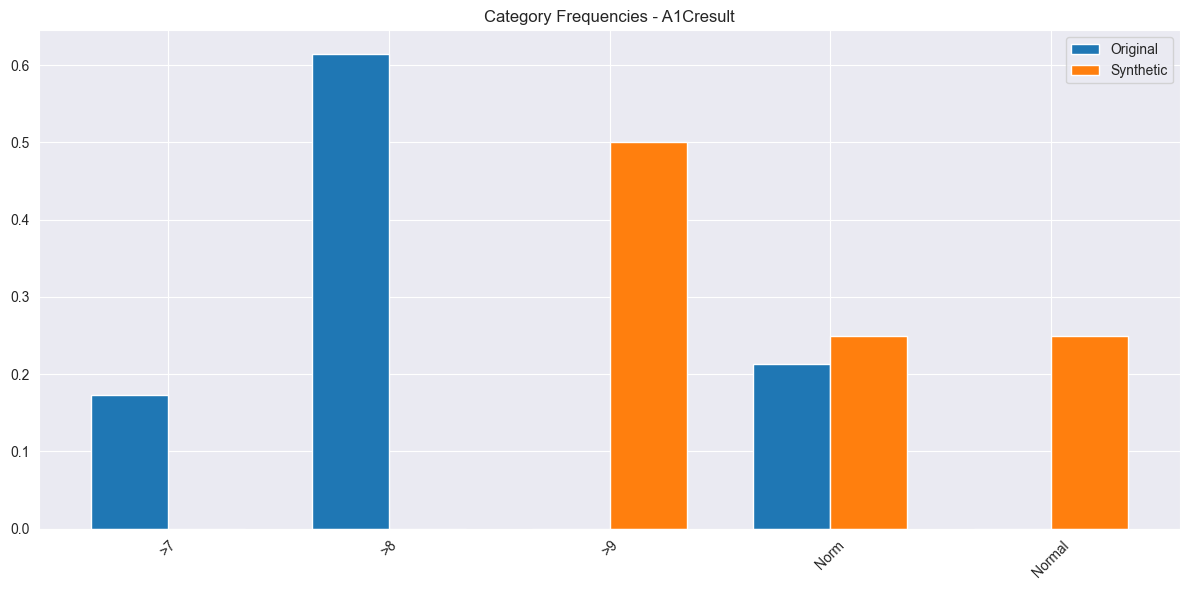

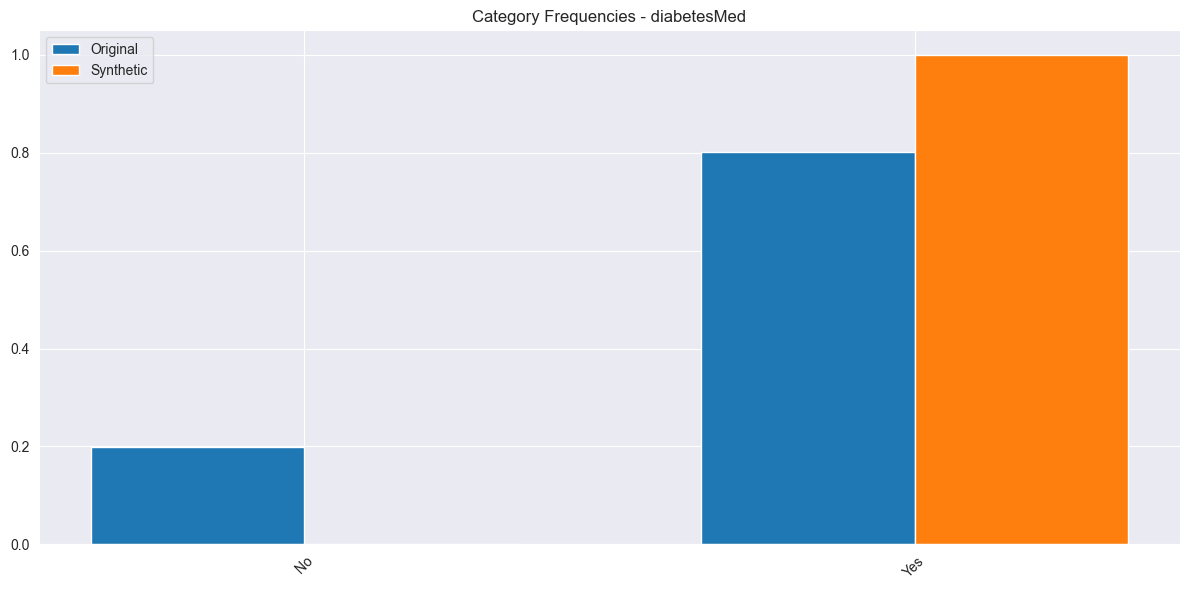

In [9]:
def plot_feature_distributions(df1, df2, column):
    """Visualizza le distribuzioni di una feature nei due dataset"""
    plt.figure(figsize=(12, 6))

    if pd.api.types.is_numeric_dtype(df1[column]):
        # Per variabili numeriche: plot delle distribuzioni
        sns.kdeplot(data=df1, x=column, label='Original', alpha=0.5)
        sns.kdeplot(data=df2, x=column, label='Synthetic', alpha=0.5)
        plt.title(f'Distribution Comparison - {column}')
    else:
        # Per variabili categoriche: plot delle frequenze relative
        freq1 = df1[column].value_counts(normalize=True)
        freq2 = df2[column].value_counts(normalize=True)

        # Combina le categorie
        categories = sorted(set(freq1.index) | set(freq2.index))

        x = np.arange(len(categories))
        width = 0.35

        plt.bar(x - width/2, [freq1.get(cat, 0) for cat in categories], width, label='Original')
        plt.bar(x + width/2, [freq2.get(cat, 0) for cat in categories], width, label='Synthetic')
        plt.xticks(x, categories, rotation=45)
        plt.title(f'Category Frequencies - {column}')

    plt.legend()
    plt.tight_layout()
    plt.show()

columns_to_plot = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'diabetesMed']

for column in columns_to_plot:
    if column in original_data.columns and column in synthetic_data.columns:
        plot_feature_distributions(original_data, synthetic_data, column)
    else:
        print(f"Attenzione: la colonna {column} non è presente in entrambi i dataset")

## 2. Pulizia delle colonne non rilevanti

In [2]:
original_data = original_data.drop(["encounter_id", "patient_nbr"], axis=1)
if "encounter_id" in synthetic_data.columns or "patient_nbr" in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(["encounter_id", "patient_nbr"], axis=1)

# TODO togliere l'id del ricovero e il payer code, RICORDATIIIIII !

### 2.1 Controlla se hai delle righe uguali

In [3]:
merged = pd.merge(original_data, synthetic_data, how='right', indicator='Exist')
merged['Exist'] = np.where(merged.Exist == 'both', True, False)
print(merged['Exist'].value_counts())

ValueError: You are trying to merge on int64 and object columns for key 'admission_type_id'. If you wish to proceed you should use pd.concat

## 3. Funzioni di Similarità per Diversi Tipi di Dati

### 3.1 Similarità con Differenze Assolute e Distanza Euclidea Normalizzata

In [4]:
def calculate_numerical_similarity(series1, series2):
    # Calcola le statistiche descrittive
    stats1 = series1.describe()
    stats2 = series2.describe()

    # Verifica se le statistiche sono disponibili
    if 'mean' not in stats1 or 'mean' not in stats2 or 'std' not in stats1 or 'std' not in stats2:
        return 0.0  # Restituisci similarità 0 se mancano le statistiche

    # Calcola le differenze normalizzate
    diff_mean = abs(stats1['mean'] - stats2['mean']) / max(abs(stats1['mean']), 1)
    diff_std = abs(stats1['std'] - stats2['std']) / max(abs(stats1['std']), 1)

    # Calcola la similarità
    similarity = 1 - (diff_mean + diff_std) / 2
    return max(0, min(1, similarity))


def calculate_categorical_similarity(series1, series2):
    """Calcola la similarità per variabili categoriche usando distribuzione delle frequenze"""
    # Calcolo delle frequenze relative
    freq1 = series1.value_counts(normalize=True)
    freq2 = series2.value_counts(normalize=True)

    # Unione di tutte le categorie
    all_categories = set(freq1.index) | set(freq2.index)

    # Normalizzazione delle frequenze
    freq1 = freq1.reindex(all_categories).fillna(0)
    freq2 = freq2.reindex(all_categories).fillna(0)

    # Calcolo della similarità usando la distanza di Jensen-Shannon
    similarity = 1 - np.sqrt(np.mean((freq1 - freq2) ** 2))
    return similarity

def calculate_overall_similarity(df1, df2):
    """Calcola la similarità complessiva tra i due dataset"""
    similarities = {}

    for column in df1.columns:
        if column in df2.columns:
            if pd.api.types.is_numeric_dtype(df1[column]):
                similarity = calculate_numerical_similarity(df1[column], df2[column])
                similarities[column] = {'type': 'numerical', 'similarity': similarity}
            else:
                similarity = calculate_categorical_similarity(df1[column], df2[column])
                similarities[column] = {'type': 'categorical', 'similarity': similarity}

    # Crea DataFrame dei risultati
    results = pd.DataFrame.from_dict(similarities, orient='index')

    # Calcola similarità media complessiva
    overall_similarity = results['similarity'].mean()

    return results, overall_similarity

# Calcola e visualizza i risultati
similarity_results, overall = calculate_overall_similarity(original_data, synthetic_data)
print(f"\nSimilarità complessiva tra i dataset: {overall:.2%}")
with open("TabularData/StoryTellingPrompt/results_storytelling.txt", "a") as f:
    f.write(f"{llm_synth}: {overall:.2%} (Differenze Assolute e Distanza Euclidea Normalizzata)\n")
print("\nSimilarità per feature:")
print(similarity_results.sort_values('similarity', ascending=False))


Similarità complessiva tra i dataset: 58.18%

Similarità per feature:
                                 type  similarity
diag_2                    categorical    0.985145
diag_1                    categorical    0.982733
diag_3                    categorical    0.981199
repaglinide               categorical    0.933360
nateglinide               categorical    0.931550
chlorpropamide            categorical    0.930033
glipizide                 categorical    0.911671
glyburide                 categorical    0.911371
medical_specialty         categorical    0.909934
metformin                 categorical    0.889043
acetohexamide             categorical    0.888889
tolbutamide               categorical    0.863992
pioglitazone              categorical    0.857213
rosiglitazone             categorical    0.855443
glyburide-metformin       categorical    0.844117
acarbose                  categorical    0.824214
payer_code                categorical    0.811505
weight                    cat

### 3.2 Similarità con KS-statistic e Jensen-Shannon

In [5]:
from scipy.stats import ks_2samp
from scipy.stats import entropy

def calculate_numerical_similarity_ks(series1, series2):
    # Converti in numerico e gestisci errori
    s1 = pd.to_numeric(series1.dropna(), errors='coerce')
    s2 = pd.to_numeric(series2.dropna(), errors='coerce')

    # Rimuovi i valori NaN risultanti dalla conversione
    s1 = s1.dropna()
    s2 = s2.dropna()

    # Verifica che ci siano abbastanza dati per il confronto
    if len(s1) == 0 or len(s2) == 0:
        return 0.0

    # Calcola la KS statistic
    ks_statistic, _ = ks_2samp(s1, s2)

    # Converte la distanza in similarità
    similarity = 1 - ks_statistic

    return similarity


def calculate_categorical_similarity_js(series1, series2):
    # Converti tutti i valori in stringhe
    series1 = series1.astype(str)
    series2 = series2.astype(str)

    # Calcola le frequenze relative
    freq1 = series1.value_counts(normalize=True)
    freq2 = series2.value_counts(normalize=True)

    # Unione di tutte le categorie
    all_categories = sorted(set(freq1.index) | set(freq2.index))

    # Normalizzazione delle frequenze con zero-padding
    p = np.array([freq1.get(cat, 0) for cat in all_categories])
    q = np.array([freq2.get(cat, 0) for cat in all_categories])

    # Calcola la divergenza di Jensen-Shannon
    m = (p + q) / 2
    divergence = (entropy(p, m) + entropy(q, m)) / 2

    # Converti la divergenza in similarità
    similarity = 1 / (1 + divergence)

    return similarity


def calculate_overall_similarity(df1, df2):
    similarities = {}

    for column in df1.columns:
        if column in df2.columns:
            if pd.api.types.is_numeric_dtype(df1[column]):
                try:
                    similarity = calculate_numerical_similarity_ks(df1[column], df2[column])
                    similarities[column] = {'type': 'numerical (KS)', 'similarity': similarity}
                except Exception as e:
                    print(f"Errore nel calcolo della similarità per la colonna {column}: {str(e)}")
                    similarities[column] = {'type': 'error', 'similarity': 0.0}
            else:
                # Gestione colonne non numeriche come prima
                similarity = calculate_categorical_similarity(df1[column], df2[column])
                similarities[column] = {'type': 'categorical', 'similarity': similarity}

    results = pd.DataFrame.from_dict(similarities, orient='index')
    overall_similarity = results['similarity'].mean()

    return results, overall_similarity


similarity_results, overall = calculate_overall_similarity(original_data, synthetic_data)
print(f"\nSimilarità complessiva tra i dataset: {overall:.2%}")
with open("TabularData/StoryTellingPrompt/results_storytelling.txt", "a") as f:
    f.write(f"{llm_synth}: {overall:.2%} (KS-statistic e Jensen-Shannon)\n\n")
print("\nSimilarità per feature:")
print(similarity_results.sort_values('similarity', ascending=False))



Similarità complessiva tra i dataset: 62.01%

Similarità per feature:
                                    type  similarity
diag_2                       categorical    0.985145
diag_1                       categorical    0.982733
diag_3                       categorical    0.981199
repaglinide                  categorical    0.933360
nateglinide                  categorical    0.931550
chlorpropamide               categorical    0.930033
glipizide                    categorical    0.911671
glyburide                    categorical    0.911371
medical_specialty            categorical    0.909934
metformin                    categorical    0.889043
acetohexamide                categorical    0.888889
tolbutamide                  categorical    0.863992
pioglitazone                 categorical    0.857213
rosiglitazone                categorical    0.855443
glyburide-metformin          categorical    0.844117
acarbose                     categorical    0.824214
payer_code                  